In [ ]:
import sys

sys.path.append('./source/')

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import integrate, stats
import matplotlib.cm as cm
from numpy import fft
from scipy import interpolate as intp
import importlib
import healpy

from source import plots
from source import prob_dists as pd
from utils import read_param_file, update_params

In [3]:
param_file = './source/n0.params'
params = read_param_file(param_file)
p = params

exposure = 5 * 14000 / (4 * np.pi)
p = update_params(param_file, p, 'exposure', exposure)

phipp = 7.12073e-30
fwimp = phipp * 8 * np.pi / 1e-28
# fwimp = 1e-4
p = update_params(param_file, p, 'fwimp', fwimp)

p = update_params(param_file, p, 'bg', 1)
p = update_params(param_file, p, 'beg', 1)

print(exposure, fwimp)
p

5570.423008216337 1.7896346444957159


{'R_G': 220,
 'd_solar': 8.5,
 'psi': 40,
 'M_min': 0.01,
 'M_max': 10000000000.0,
 'fwimp': 1.7896346444957159,
 'mean_params': {'a': 77.4, 'b': 0.87, 'c': -0.23},
 'nside': 128,
 'area_fermi': 2000.0,
 'n': 0,
 'log_flux_min': -15,
 'log_flux_max': -5,
 'N': 1000,
 'log_k_min': -3,
 'log_k_max': 6,
 'N_k': 250000,
 'psh_log_f_min': -7,
 'psh_log_f_max': -2.5,
 'N_psh': 1000,
 'omega_pixel': 6.391586616190171e-05,
 'exposure': 5570.423008216337,
 'iso_flux_bg': 0.0008939106670451649,
 'gal_flux_bg_file': './output/gal_flux_bg.npy',
 'bg': 1,
 'beg': 1}

In [4]:
nside = p['nside']
npix = healpy.nside2npix(nside)
lon, lat = healpy.pix2ang(nside, range(npix), lonlat=True)
ang_dists = np.rad2deg(np.arccos(np.cos(np.deg2rad(lon)) * np.cos(np.deg2rad(lat))))
good_indices = (abs(lat) >= 40)

In [5]:
## S-WAVE
s_psh, s_pshfunc2d, s_fluxes, _ = pd.psh_s(ang_dists[good_indices], return_all=True)

## SOM
som_psh, som_pshfunc2d, som_fluxes, _= pd.psh_som(ang_dists[good_indices], return_all=True)

In [6]:
# search parameters
num_search = 50
p['fwimp'] *= 1

fwimps = np.logspace(np.log10(p['fwimp'])-.5, np.log10(p['fwimp'])+.5, num_search)
begs = np.linspace(.9, 1.1, num=40)

exposure_search = np.logspace(0, 1, num=1) * p['exposure']
exposure_search = np.array([2]) * p['exposure']

In [7]:
 def likelihood_run_for_model_2d(psh, fluxes, poisson_rescale=1, model=''):
    # run likelihoods
    s_S = np.zeros((len(exposure_search), len(begs), num_search))
    som_S = np.zeros((len(exposure_search), len(begs), num_search))
    poisson_S = np.zeros((len(exposure_search), len(begs), num_search))

    total, mean, std, meanpc = [], [], [], []
    for i, exposure in enumerate(exposure_search):
        p['exposure'] = exposure

        gal_bg = np.load(p['gal_flux_bg_file'])[good_indices] * p['exposure'] * p['bg']
        iso_bg = p['iso_flux_bg'] * p['exposure'] * p['beg']
        bg_count = gal_bg + iso_bg

        counts = np.arange(0, bg_count.max() + p['exposure'] * p['fwimp'] * fluxes.max() + 9 * np.sqrt(p['exposure'] * p['fwimp'] * fluxes.max()))

        print('calculating pc to count =', counts[-1])

        unique_ang, uni_ind, uni_inv = np.unique(np.abs(ang_dists[good_indices]), return_inverse=True, return_index=True)

        pshdat = psh[:, uni_ind]
        psh = pshdat[:, uni_inv]
        if model == 's':
            spsh = pshdat[:, uni_inv]
            sompsh = som_psh
        elif model == 'som':
            sompsh = pshdat[:, uni_inv]
            spsh = s_psh

        pc_psi = integrate.simps(pshdat[..., np.newaxis] * stats.poisson.pmf(counts[np.newaxis, np.newaxis, :], p['exposure'] * p['fwimp'] * fluxes[:, np.newaxis, np.newaxis]), fluxes, axis=0)
        pc_psi /= np.sum(pc_psi, axis=-1)[:, np.newaxis]

        print('is pc norm', np.allclose(np.sum(pc_psi, axis=-1), 1))
        print('last pc prob', pc_psi[:, -1])

        pc_of_psi = pc_psi[uni_inv]

        # generate sky map
        subcounts = pd.generate_skymap_sample_pc(p, pc_of_psi, ang_dists[good_indices], good_indices, return_subcounts=True, save_output=True, bg_counts=bg_count)

        print('generated skymap with', p['fwimp'])
        print('max counts', counts[-1], subcounts.max())

        S = pd.likelihood2d(p, spsh, subcounts.astype(np.int16), s_fluxes, fwimps, begs, eg_bg_count=iso_bg, g_bg_count=gal_bg)
        s_S[i] = S
        print('finish swave')

        S = pd.likelihood2d(p, sompsh, subcounts.astype(np.int16), som_fluxes, fwimps/100, begs, eg_bg_count=iso_bg, g_bg_count=gal_bg)
        som_S[i] = S
        print('finish som')

        S = pd.poisson_likelihood2d(p, psh, subcounts.astype(np.int16), fluxes, fwimps/poisson_rescale, begs, eg_bg_count=iso_bg, g_bg_count=gal_bg)
        poisson_S[i] = S
        print('finish poi')

        print(i+1, '/', len(exposure_search))
        
    return [s_S, som_S, poisson_S]

In [8]:
SS = []

SS.append(likelihood_run_for_model_2d(s_psh, s_fluxes, model='s'))
p['fwimp'] /= 100
SS.append(likelihood_run_for_model_2d(som_psh, som_fluxes, model='som', poisson_rescale=100))


calculating pc to count = 189.0
is pc norm True
last pc prob [8.80030443e-97 8.88451172e-97 8.80030443e-97 ... 8.88257063e-97
 8.74193289e-97 8.88257063e-97]
saved in ./output/n0_skymap_96164.npy
generated skymap with 1.7896346444957159
max counts 189.0 126.0
finish swave
finish som
finish poi
1 / 1
calculating pc to count = 122.0
is pc norm True
last pc prob [2.13580312e-299 1.21321444e-296 2.13580312e-299 ... 1.18531036e-296
 2.07544513e-299 1.18531036e-296]
saved in ./output/n0_skymap_06738.npy
generated skymap with 0.01789634644495716
max counts 122.0 132.0
finish swave
finish som
finish poi
1 / 1


<ipython-input-12-4326ee5ec776>:20: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contourf(fwimps, begs, np.exp(-0.5*(expdat - expdat.min())), label=f'{expo:.2}cm2s')
<ipython-input-12-4326ee5ec776>:13: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contourf(fwimps / 100, begs, np.exp(-0.5*(expdat - expdat.min())), label=f'{expo:.2}cm2s')
<ipython-input-12-4326ee5ec776>:43: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contourf(fwimps, begs, np.exp(-0.5*(expdat - expdat.min())), label=f'{expo:.2}cm2s')
<ipython-input-12-4326ee5ec776>:36: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contourf(fwimps / 100, begs, np.exp(-0.5*(expdat - expdat.min())), label=f'{expo:.2}cm2s')
No handles with labels found to put in legend.


1.7896346444957159


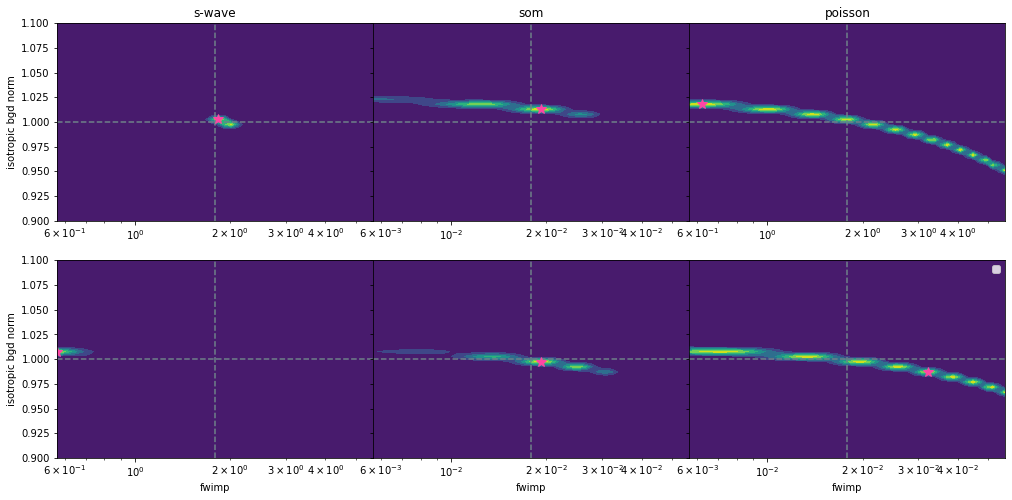

In [12]:
fig, axss = plt.subplots(ncols=3, nrows=2, figsize=(17, 8), sharey=True, gridspec_kw={'wspace': 0})
i = 0
lw = 5
zorder = 1
p['fwimp'] *= 100
axs = axss[0]

for ax, s, lab in zip(axs, SS[0], ['s-wave L', 'som L', 'poisson L']):
    colors = iter(['xkcd:mulberry', 'xkcd:wheat', 'xkcd:mossy green', 'xkcd:cool blue', 'xkcd:blush pink'])
    for expdat, expo in zip(s, exposure_search):
        indmax = np.unravel_index(np.argmin(expdat, axis=None), expdat.shape)
        if lab == 'som L':
            ax.contourf(fwimps / 100, begs, np.exp(-0.5*(expdat - expdat.min())), label=f'{expo:.2}cm2s')
            ax.axvline(p['fwimp']/100, ls='--', color='xkcd:steel gray')
            ax.axhline(1, ls='--', color='xkcd:steel gray')
            ax.plot(fwimps[indmax[1]]/100, begs[indmax[0]], marker='*', color='xkcd:barbie pink', ms=10)
#             ax.plot(fwimps/100, expdat - expdat.min(), label=f'{expo:.2}cm2s')
#             print(lab, expdat.min(),  '\t', fwimps[np.exp(-0.5*(expdat - expdat.min())).argmax()]/100)
        else:
            ax.contourf(fwimps, begs, np.exp(-0.5*(expdat - expdat.min())), label=f'{expo:.2}cm2s')
            ax.axvline(p['fwimp'], ls='--', color='xkcd:steel gray')
            ax.axhline(1, ls='--', color='xkcd:steel gray')
            ax.plot(fwimps[indmax[1]], begs[indmax[0]], marker='*', color='xkcd:barbie pink', ms=10)
#             ax.plot(fwimps, expdat - expdat.min(), label=f'{expo:.2}cm2s')
#             print(lab, expdat.min(),  '\t', fwimps[np.exp(-0.5*(expdat - expdat.min())).argmax()])

    ax.set_xscale('log')
    
axs = axss[1]
# p['fwimp'] /=100
for ax, s, lab in zip(axs, SS[1], ['s-wave L', 'som L', 'poisson L']):
    colors = iter(['xkcd:mulberry', 'xkcd:wheat', 'xkcd:mossy green', 'xkcd:cool blue', 'xkcd:blush pink'])
    for expdat, expo in zip(s, exposure_search):
        indmax = np.unravel_index(np.argmin(expdat, axis=None), expdat.shape)
        if lab == 'som L' or lab == 'poisson L':
            ax.contourf(fwimps / 100, begs, np.exp(-0.5*(expdat - expdat.min())), label=f'{expo:.2}cm2s')
            ax.axvline(p['fwimp'] / 100, ls='--', color='xkcd:steel gray')
            ax.axhline(1, ls='--', color='xkcd:steel gray')
            ax.plot(fwimps[indmax[1]]/100, begs[indmax[0]], marker='*', color='xkcd:barbie pink', ms=10)
#             ax.plot(fwimps/100, expdat - expdat.min(), label=f'{expo:.2}cm2s')
#             print(lab, expdat.min(),  '\t', fwimps[np.exp(-0.5*(expdat - expdat.min())).argmax()]/100)
        else:
            ax.contourf(fwimps, begs, np.exp(-0.5*(expdat - expdat.min())), label=f'{expo:.2}cm2s')
            ax.axvline(p['fwimp'], ls='--', color='xkcd:steel gray')
            ax.axhline(1, ls='--', color='xkcd:steel gray')
            ax.plot(fwimps[indmax[1]], begs[indmax[0]], marker='*', color='xkcd:barbie pink', ms=10)
#             ax.plot(fwimps, expdat - expdat.min(), label=f'{expo:.2}cm2s')
#             print(lab, expdat.min(),  '\t', fwimps[np.exp(-0.5*(expdat - expdat.min())).argmax()])

    ax.set_xscale('log')
# p['fwimp'] *= 100 
for ax in axss[-1]:
    ax.set_xlabel('fwimp')
    
axss[0, 0].set_ylabel('isotropic bgd norm')
axss[1, 0].set_ylabel('isotropic bgd norm')

axss[0, 0].set_title('s-wave')
axss[0, 1].set_title('som')
axss[0, 2].set_title('poisson')
    
axss.flatten()[-1].legend()
#     ax.set_yscale('log')
#     ax.set_ylim(bottom=0, top=10)
print(p['fwimp'])
fig.savefig('./output/llhds_2d.pdf')

Add:
- Float beg but fix bg to 0.97
- Float beg w/ same bg
- Generate w/ no DM signal and fit s/som/poi (null test)
- Add to overleaf
- 

6.889319429756142


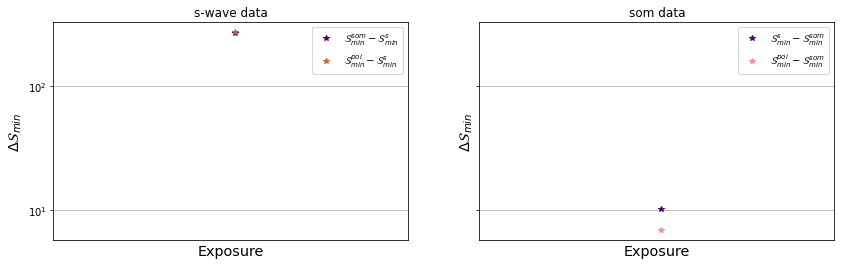

In [14]:
fig, axs = plt.subplots(ncols=2, figsize=(14,4), sharey=True, sharex=True)

ax = axs[0]
s_S, som_S, poisson_S = SS[0]
max_swave = np.amin(s_S)
max_som = np.amin(som_S)
max_poi = np.amin(poisson_S)
ax.plot(exposure_search, -max_swave + max_som, ls='', marker='*', color='xkcd:royal purple', label=r'$\mathcal{S}_{min}^{som} - \mathcal{S}_{min}^{s}$')
ax.plot(exposure_search, -max_swave + max_poi, ls='', marker='*', color='xkcd:terra cotta', label=r'$\mathcal{S}_{min}^{poi} - \mathcal{S}_{min}^{s}$')
# ax.plot(exposure_search, max_som - max_poi, ls='', marker='*', color='xkcd:pink', label=r'$\mathcal{S}_{min}^{som} - \mathcal{S}_{min}^{poi}$')
ax.set_xscale('symlog')
ax.set_yscale('symlog')
ax.grid()
# ax.set_ylim(bottom=10)
ax.set_ylabel(r'$\Delta\mathcal{S}_{min}$', fontsize='x-large')
ax.set_xlabel(r'Exposure', fontsize='x-large')
ax.legend()
 
ax = axs[1]
s_S, som_S, poisson_S = SS[1]
max_swave = np.amin(s_S)
max_som = np.amin(som_S)
max_poi = np.amin(poisson_S)
ax.plot(exposure_search, max_swave - max_som, ls='', marker='*', color='xkcd:royal purple', label=r'$\mathcal{S}_{min}^{s} - \mathcal{S}_{min}^{som}$')
# ax.plot(exposure_search, max_swave - max_poi, ls='', marker='*', color='xkcd:terra cotta', label=r'$\mathcal{S}_{min}^{s} - \mathcal{S}_{min}^{poi}$')
ax.plot(exposure_search, - max_som + max_poi, ls='', marker='*', color='xkcd:pink', label=r'$\mathcal{S}_{min}^{poi} - \mathcal{S}_{min}^{som}$')
ax.set_xscale('symlog')
ax.set_yscale('symlog')
ax.grid()
# ax.set_ylim(bottom=10)
ax.set_ylabel(r'$\Delta\mathcal{S}_{min}$', fontsize='x-large')
ax.set_xlabel(r'Exposure', fontsize='x-large')
ax.legend()
print(max_poi - max_som)
axs[0].set_title('s-wave data')
axs[1].set_title('som data')

fig.savefig('./output/deltaS_2d.pdf')

In [ ]:
fig, axs = plt.subplots(ncols=3, figsize=(15,4))
axs[0].plot(exposure_search, mean, label='mean', marker='o', ms=10)
axs[0].set_title('mean counts')
axs[1].plot(exposure_search, meanpc, label='P(C) mean', marker='o', ms=10)
axs[1].set_title('mean P(C)')
axs[2].plot(exposure_search, total, label='P(C) mean', marker='o', ms=10)
axs[2].set_title('total counts')

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
# ax.set_ylim(bottom=0, top=)
ax.set_yscale('log')
ax.set_ylabel('Exposure [cm2 s]')
ax.set_xscale('log')
ax.set_xlabel('fwimp')
pc = ax.pcolormesh(fwimps, exposure_search, np.log10(s_S), cmap=cm.jet, shading='auto')
fig.colorbar(pc, label='S for s-wave');

In [ ]:
max_swave = np.amin(s_S, axis=-1)
max_som = np.amin(som_S, axis=-1)
max_poi = np.amin(poisson_S, axis=-1)